# In this Notebook...
- Data preparation
- Data cleansing
- Data visualization

# Imports

In [15]:
import pandas as pd
from matplotlib import pyplot as plt
from pipetorch import DFrame
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Data and Statistics

In [16]:
#load datasets
ingr = pd.read_csv('/data/foodboost/ingredients.csv', index_col=0)
nutr = pd.read_csv('/data/foodboost/nutritions.csv', index_col=0)
recp = pd.read_csv('/data/foodboost/recipes.csv', index_col=0)
tags = pd.read_csv('/data/foodboost/tags.csv', index_col=0)

recp.head()

,title,persons,time,calories,stars,url,image
0,Kruidnoten met choco-discodip,4,25,260,0,https://www.ah.nl/allerhande/recept/R-R1195893...,https://static.ah.nl/static/recepten/img_RAM_P...
0,Kruidnoten in marsepein,4,25,265,0,https://www.ah.nl/allerhande/recept/R-R1195892...,https://static.ah.nl/static/recepten/img_RAM_P...
0,Kruidnoten met chocodips,4,25,335,0,https://www.ah.nl/allerhande/recept/R-R1195891...,https://static.ah.nl/static/recepten/img_RAM_P...
0,Pepernotentaart met marsepeinstrik,10,30,560,0,https://www.ah.nl/allerhande/recept/R-R1195887...,https://static.ah.nl/static/recepten/img_RAM_P...
0,Perencake,12,10,265,0,https://www.ah.nl/allerhande/recept/R-R1195790...,https://static.ah.nl/static/recepten/img_RAM_P...


In [17]:
#put all tags of a recipe in one column (long string)
nutr_cal = nutr.loc[nutr['nutrition'] == 'energie']
nutr_eiw = nutr.loc[nutr['nutrition'] == 'eiwit']
tags['jointags'] = tags[['recipe', 'tag']].groupby(['recipe'])['tag'].transform(lambda x: ','.join(x))
tags_join = tags[['recipe', 'jointags']]
tags_join.drop_duplicates(inplace=True, ignore_index=True)
tags_join.head()

/tmp/ipykernel_47183/3721027905.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tags_join.drop_duplicates(inplace=True, ignore_index=True)


,recipe,jointags
0,Kruidnoten met choco-discodip,"hollands,gebak,gebak,sinterklaas,sinterklaasavond"
1,Kruidnoten in marsepein,"hollands,gebak,gebak,sinterklaas,sinterklaasavond"
2,Kruidnoten met chocodips,"hollands,gebak,gebak,sinterklaas,sinterklaasavond"
3,Pepernotentaart met marsepeinstrik,"oven,hollands,gebak,gebak,sinterklaas,sinterkl..."
4,Perencake,"vooraf te maken,oven,gebak,gebak"


In [18]:
#add a column of any nutritions
nutr_new = pd.merge(nutr_cal, nutr_eiw[['recipe', 'value']], how = 'outer', left_on = 'recipe', right_on = 'recipe')
nutr_new.fillna('0 g', inplace=True)
nutr_new = pd.merge(nutr_new, tags_join[['recipe', 'jointags']], how = 'outer', left_on = 'recipe', right_on = 'recipe')
nutr_new.fillna('*no tags', inplace=True)
nutr_new['calorieën'] = nutr_new['value_x'].map(lambda x: int(x.rstrip(' kcal')))
nutr_new['eiwitten'] = nutr_new['value_y'].map(lambda x: float(x.rstrip(' g')))
nutr_new = nutr_new.drop(columns=['value_x', 'value_y', 'nutrition'])
nutr_new.head()

,recipe,jointags,calorieën,eiwitten
0,Kruidnoten met choco-discodip,"hollands,gebak,gebak,sinterklaas,sinterklaasavond",260,3.0
1,Kruidnoten in marsepein,"hollands,gebak,gebak,sinterklaas,sinterklaasavond",265,3.0
2,Kruidnoten met chocodips,"hollands,gebak,gebak,sinterklaas,sinterklaasavond",335,5.0
3,Pepernotentaart met marsepeinstrik,"oven,hollands,gebak,gebak,sinterklaas,sinterkl...",560,5.0
4,Perencake,"vooraf te maken,oven,gebak,gebak",265,5.0


In [19]:
#use the joined tags to detect the recipes that contain 'lunch', 'diner' or 'hoofdgerecht'
nutr_new_lunch = nutr_new[nutr_new['jointags'].str.contains('lunch')]
nutr_new_diner = nutr_new[nutr_new['jointags'].str.contains('diner')]
nutr_new_hoofdg = nutr_new[nutr_new['jointags'].str.contains('hoofdgerecht')]
nutr_new_avond = pd.concat([nutr_new_diner,nutr_new_hoofdg],axis=0)

In [20]:
#show potential outliers for lunch
nutr_new_lunch.sort_values('calorieën', ascending=False).head()

,recipe,jointags,calorieën,eiwitten
5487,Roggebrood met noten en bessen,"vegetarisch,vooraf te maken,oven,brood/sandwic...",3320,104.0
5719,Zelfgemaakte pindakaas,"vegetarisch,glutenvrij,lactosevrij,oven,brunch...",3085,113.0
1168,Zuurdesembrood,"lactosevrij,brood/sandwiches,brunch,borrelhapj...",2465,82.0
5690,Vlechtbrood met maanzaad,"zonder vlees/vis,oven,hollands,brood/sandwiche...",2315,81.0
8179,Aardbeienjam maken,"glutenvrij,lactosevrij,vooraf te maken,holland...",1935,4.0


In [21]:
#show potential outliers for diner
nutr_new_avond.sort_values('calorieën', ascending=False).head()

,recipe,jointags,calorieën,eiwitten
8293,Lasagne met roomsaus,"oven,italiaans,pasta,hoofdgerecht",1345,45.0
2258,Beef rendang met basmatirijst,hoofdgerecht,1250,59.0
5040,"Eend met 5 spices, sinaasappel en gember met p...","oven,aziatisch,hoofdgerecht,oud &amp; nieuw,kerst",1240,33.0
7576,Varkenshaas en croûte,"oven,hoofdgerecht,kerst",1215,68.0
241,Pizza al tartufo,"oven,italiaans,hoofdgerecht",1190,38.0


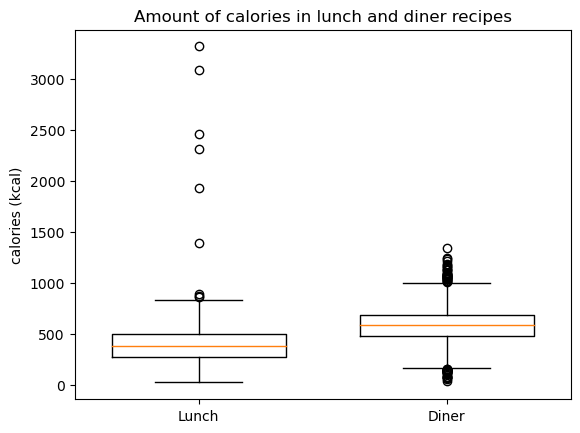

In [22]:
#boxplots to see if any outliers
kcaldict = {'Lunch':list(nutr_new_lunch['calorieën']), 'Diner':list(nutr_new_avond['calorieën'])}

plt.boxplot(kcaldict.values(), labels=kcaldict.keys(), widths = (0.7,0.7))
plt.title('Amount of calories in lunch and diner recipes')
plt.ylabel('calories (kcal)')
plt.savefig('Boxplotkcal.png',dpi=300)
plt.show()

In [23]:
#get boxplot data
def fences(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3-Q1
    LF = Q1 - (1.5*IQR)
    UF = Q3 + (1.5*IQR)
    return (LF,UF)

boxplotdata = {}
boxplotdata['lunch'] = fences(nutr_new_lunch['calorieën'])
boxplotdata['diner'] = fences(nutr_new_avond['calorieën'])
print(boxplotdata)

{'lunch': (-75.0, 845.0), 'diner': (165.0, 1005.0)}


In [24]:
#drop lunch and diner recipes outside lower and upper fences
nutr_new_lunch = nutr_new_lunch.loc[nutr_new_lunch['calorieën'] < 845]
nutr_new_avond = nutr_new_avond.loc[nutr_new_avond['calorieën'] > 165]
nutr_new_avond = nutr_new_avond.loc[nutr_new_avond['calorieën'] < 1005]

#create combinations of every lunch with every diner
nutr_allcombo = nutr_new_lunch.merge(nutr_new_avond, how = 'cross')
nutr_allcombo = nutr_allcombo.drop(['jointags_x', 'jointags_y','eiwitten_x', 'eiwitten_y'], axis=1)
nutr_allcombo.rename(columns={'recipe_x': 'lunch_recipe', 'calorieën_x': 'lunch_kcal', 'recipe_y': 'diner_recipe', 'calorieën_y': 'diner_kcal'}, inplace=True)
nutr_allcombo['som_kcal'] = nutr_allcombo['lunch_kcal'] + nutr_allcombo['diner_kcal']
nutr_allcombo.head()

,lunch_recipe,lunch_kcal,diner_recipe,diner_kcal,som_kcal
0,"Wortelwraps met kikkererwten, paprika en tzatz...",280,Viscurry met spinazie en kikkererwten,305,585
1,"Wortelwraps met kikkererwten, paprika en tzatz...",280,Thaise scholspiesjes met kruidige rijst en wor...,495,775
2,"Wortelwraps met kikkererwten, paprika en tzatz...",280,Gebakken scholfilet met lauwwarme rijstsalade,550,830
3,"Wortelwraps met kikkererwten, paprika en tzatz...",280,Gegrilde scholfilet met couscous-venkelsalade,585,865
4,"Wortelwraps met kikkererwten, paprika en tzatz...",280,Gnocchi met spek en pecorino,330,610


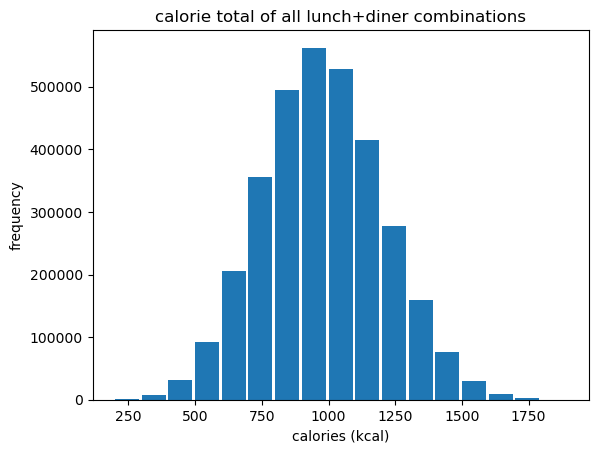

In [25]:
#histogram to see distribution of amount of calories of lunch+diner combos
kcal_combinations = nutr_allcombo.sample(frac=1)['som_kcal']
step = range(min(kcal_combinations), max(kcal_combinations) + 100, 100)
plt.title('calorie total of all lunch+diner combinations')
plt.xlabel('calories (kcal)')
plt.ylabel('frequency')
plt.hist(kcal_combinations, bins=step, rwidth=0.9)
plt.savefig('histogramkcal.png',dpi=300)
plt.show()